In [1]:
%env DDE_BACKEND=tensorflow
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

env: DDE_BACKEND=tensorflow


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
# Parallelization
dde.config.set_parallel_scaling('weak') # Nao paralelo
# dde.config.set_parallel_scaling('strong') # Ativa paralelização

In [3]:
rho = 1
mu = 1
u_in = 1
D = 1
L = 2


In [4]:
geom = dde.geometry.Rectangle(xmin=[-L/2,-D/2],xmax=[L/2,D/2])

In [5]:
def upper_wall(X, on_boundary):
  on_upper_wall = np.logical_and(np.logical_and(np.isclose(X[1],D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)), on_boundary)
  return on_upper_wall

def lower_wall(X, on_boundary):
  on_lower_wall = np.logical_and(np.logical_and(np.isclose(X[1],-D/2,rtol=1e-05,atol=1e-08), np.not_equal(X[0],-L/2)),on_boundary)
  return on_lower_wall

def boundary_inlet(X,on_boundary):
  on_inlet = np.logical_and(np.isclose(X[0],-L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_inlet

def boundary_outlet(X,on_boundary):
  on_outlet = np.logical_and(np.isclose(X[0],L/2,rtol=1e-05,atol=1e-08),on_boundary)
  return on_outlet

In [6]:
def zero(x):
    return 0.

def inlet_u(x):
    return u_in

bc_wall_u_up = dde.DirichletBC(geom, zero, upper_wall, component=0)
bc_wall_u_down = dde.DirichletBC(geom, zero, lower_wall, component=0)
bc_wall_v_up = dde.DirichletBC(geom, zero, upper_wall, component=1)
bc_wall_v_down = dde.DirichletBC(geom, zero, lower_wall, component=1)

bc_inlet_u = dde.DirichletBC(geom, inlet_u, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, zero, boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, zero, boundary_outlet, component=2)
bc_outlet_v = dde.DirichletBC(geom, zero, boundary_outlet, component=1)

In [7]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i=0, j=0)
    du_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dv_x = dde.grad.jacobian(Y, X, i=1, j=0)
    dv_y = dde.grad.jacobian(Y, X, i=1, j=1)
    dp_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dp_y = dde.grad.jacobian(Y, X, i=2, j=1)

    # Definições para newtoniano para componentes do tensor de tensão
    tau_xy =  mu * (du_y + dv_x)
    tau_xx =  2 * mu * du_x
    tau_yx =  mu * (dv_x + du_y)
    tau_yy =  2 * mu * dv_y

    # Derivadas dos tensores de tensão
    dtau_xx_x = dde.grad.jacobian(tau_xx, X, i=0, j=0)
    dtau_xy_x = dde.grad.jacobian(tau_xy, X, i=0, j=0)
    dtau_yx_y = dde.grad.jacobian(tau_yx, X, i=0, j=1)
    dtau_yy_y = dde.grad.jacobian(tau_yy, X, i=0, j=1)

    # Termos de advecção para as componentes u e v
    advec_u = Y[:,0:1] * du_x + Y[:,1:2] * du_y
    advec_v = Y[:,0:1] * dv_x + Y[:,1:2] * dv_y
    
    # Tensões na particula fluida
    tensao_x =  dp_x -  dtau_yx_y - dtau_xx_x
    tensao_y =  dp_y -  dtau_xy_x - dtau_yy_y

    # Equações de Navier-Stokes modificadas para incluir todos os tensores de tensão
    pde_u = rho * advec_u + tensao_x
    pde_v = rho * advec_v + tensao_y
    
    # Equação de continuidade
    pde_cont = du_x + dv_y  

    return [pde_u, pde_v, pde_cont]

In [8]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u_up,bc_wall_u_down,bc_wall_v_up,bc_wall_v_down,bc_inlet_u,bc_inlet_v,bc_outlet_p,bc_outlet_v],
                    num_domain = 2000,
                    num_boundary = 2000,
                    num_test = 200)

<function matplotlib.pyplot.show(close=None, block=None)>

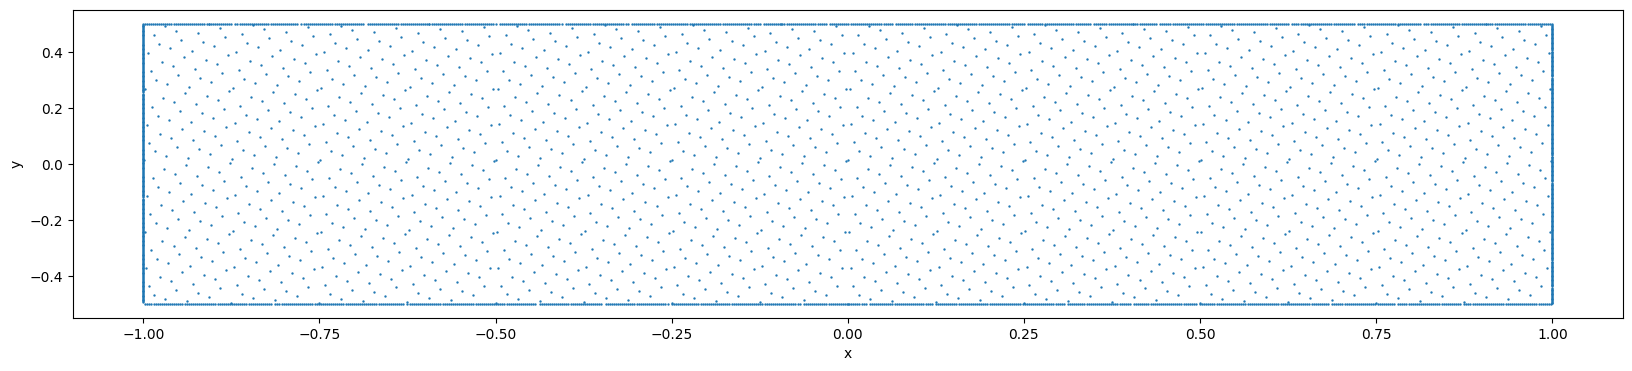

In [9]:
plt.figure(figsize=(20,4))
plt.scatter(data.train_x_all[:,0],data.train_x_all[:,1],s=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.show

In [10]:
net = dde.maps.FNN([2]+[64]*5+[3], "tanh","Glorot uniform")

In [11]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000994 s



In [12]:
losshistory,train_state = model.train(epochs = 10000, display_every=100)

Training model...



c:\Users\Matuchaki\AppData\Local\pypoetry\Cache\virtualenvs\deepxde-custom-E_cFIhQu-py3.10\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [3.59e-02, 8.77e-02, 2.16e-02, 1.22e-02, 1.21e-02, 4.33e-03, 4.32e-03, 1.39e+00, 1.29e-02, 2.34e-02, 1.28e-02]    [3.33e-02, 9.45e-02, 2.33e-02, 1.22e-02, 1.21e-02, 4.33e-03, 4.32e-03, 1.39e+00, 1.29e-02, 2.34e-02, 1.28e-02]    []  
100       [1.22e-04, 3.16e-04, 2.44e-02, 8.94e-02, 8.82e-02, 1.28e-02, 1.28e-02, 1.68e-01, 3.90e-03, 9.04e-06, 3.85e-03]    [5.85e-05, 1.59e-04, 2.57e-02, 8.94e-02, 8.82e-02, 1.28e-02, 1.28e-02, 1.68e-01, 3.90e-03, 9.04e-06, 3.85e-03]    []  
200       [1.26e-02, 5.42e-04, 3.24e-02, 7.02e-02, 7.19e-02, 1.38e-02, 1.18e-02, 1.30e-01, 4.76e-03, 1.77e-05, 2.67e-03]    [5.94e-03, 3.09e-04, 3.11e-02, 7.02e-02, 7.19e-02, 1.38e-02, 1.18e-02, 1.30e-01, 4.76e-03, 1.77e-05, 2.67e-03]    []  
300       [1.44e-02, 

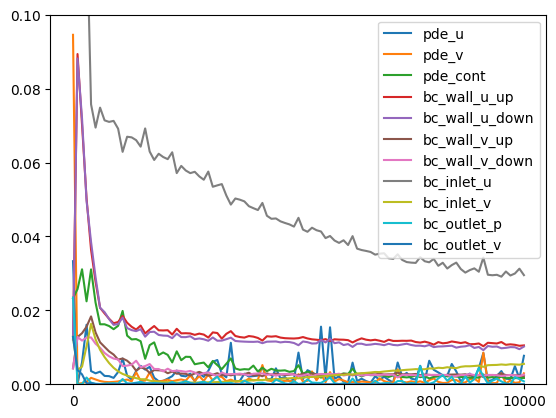

In [13]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [14]:
dde.optimizers.config.set_LBFGS_options(maxiter = 3000)
model.compile("L-BFGS")
losshistory,train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False , isplot = False)

Compiling model...
'compile' took 0.177078 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
10000     [1.71e-02, 3.76e-03, 2.91e-03, 1.05e-02, 1.02e-02, 2.21e-03, 2.61e-03, 2.95e-02, 5.51e-03, 7.90e-04, 2.35e-05]    [7.71e-03, 2.96e-03, 1.70e-03, 1.05e-02, 1.02e-02, 2.21e-03, 2.61e-03, 2.95e-02, 5.51e-03, 7.90e-04, 2.35e-05]    []  
13000     [5.27e-04, 7.10e-04, 1.34e-03, 4.42e-03, 3.87e-03, 7.59e-04, 7.36e-04, 9.88e-03, 2.15e-03, 4.97e-05, 4.88e-07]    [3.67e-04, 5.44e-04, 1.10e-03, 4.42e-03, 3.87e-03, 7.59e-04, 7.36e-04, 9.88e-03, 2.15e-03, 4.97e-05, 4.88e-07]    []  

Best model at step 13000:
  train loss: 2.44e-02
  test loss: 2.39e-02
  test metric: []

'train' took 4225.819519 s



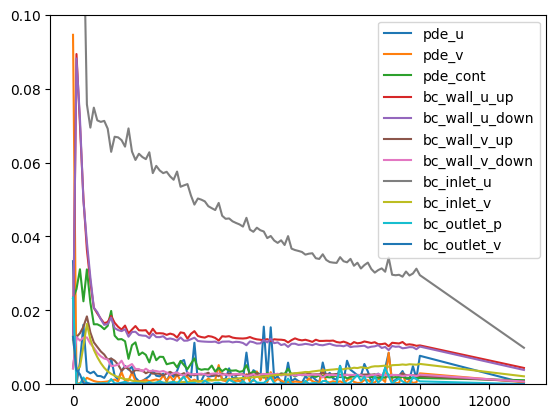

In [15]:
plot_array = np.array(losshistory.loss_test)
plot_labels = ["pde_u", "pde_v", "pde_cont", "bc_wall_u_up", "bc_wall_u_down", "bc_wall_v_up", "bc_wall_v_down", "bc_inlet_u", "bc_inlet_v", "bc_outlet_p", "bc_outlet_v"]
# plot_array = np.array(losshistory.loss_train)
for i in range(plot_array.shape[1]):
    plt.plot(losshistory.steps, plot_array[:,i], label=plot_labels[i])
    
plt.legend()
plt.ylim([0, 0.1])
plt.show()

In [16]:
samples= geom.random_points(500000)
result = model.predict(samples)

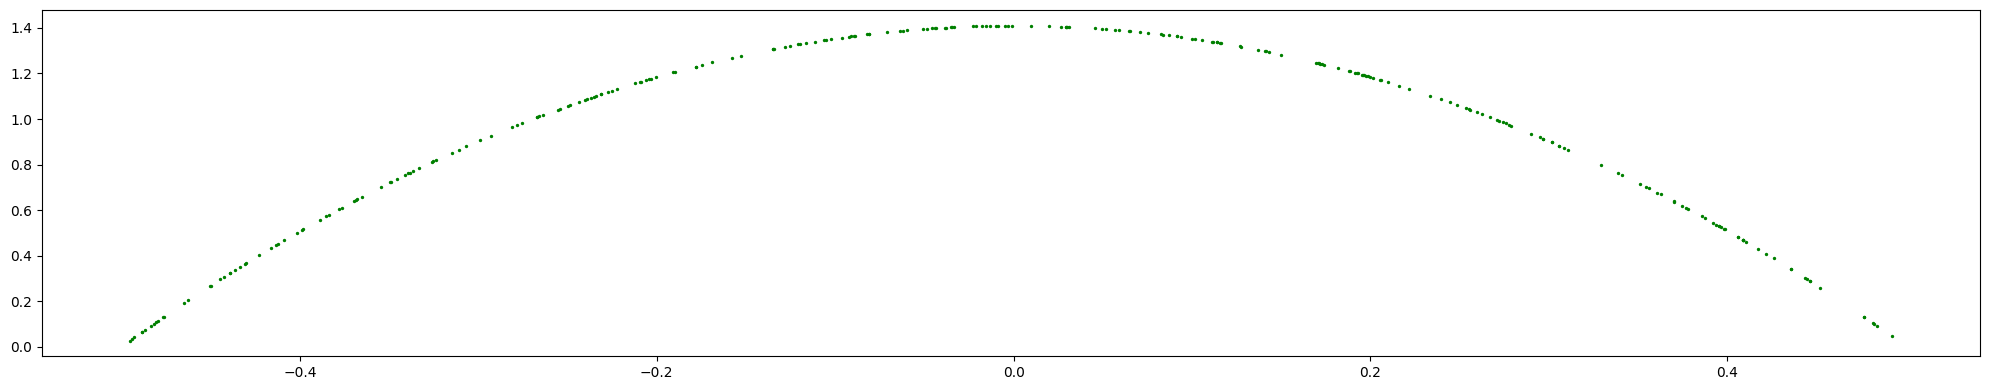

In [17]:
color_legend=[[0,1.5],[-0.3,0.3],[0,35]]
# for idx in range(3):
plt.figure(figsize=(20,4))
mask = np.where((samples[:,0] > (D/2 - 0.001)) & (samples[:,0] <= D/2))
plt.scatter(samples[mask,1], result[mask,0], c='green',s=2)
mask = np.where((samples[:,0] < -(D/2 + 0.001)) & (samples[:,0] >= -D/2))
plt.scatter(samples[mask,1], result[mask,0], c='red',s=2)
plt.tight_layout()
plt.show()

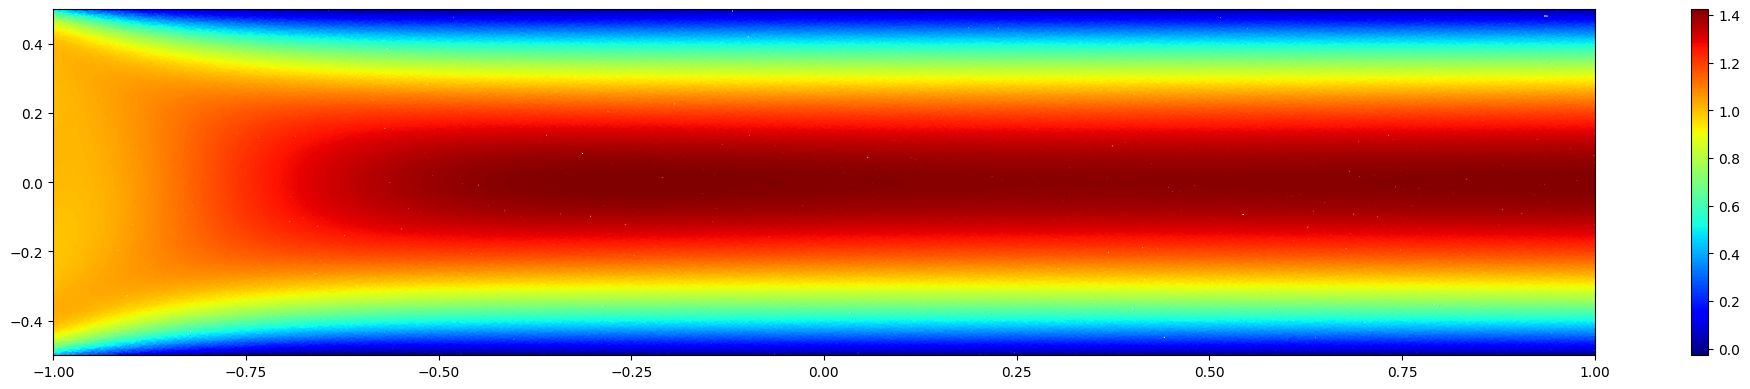

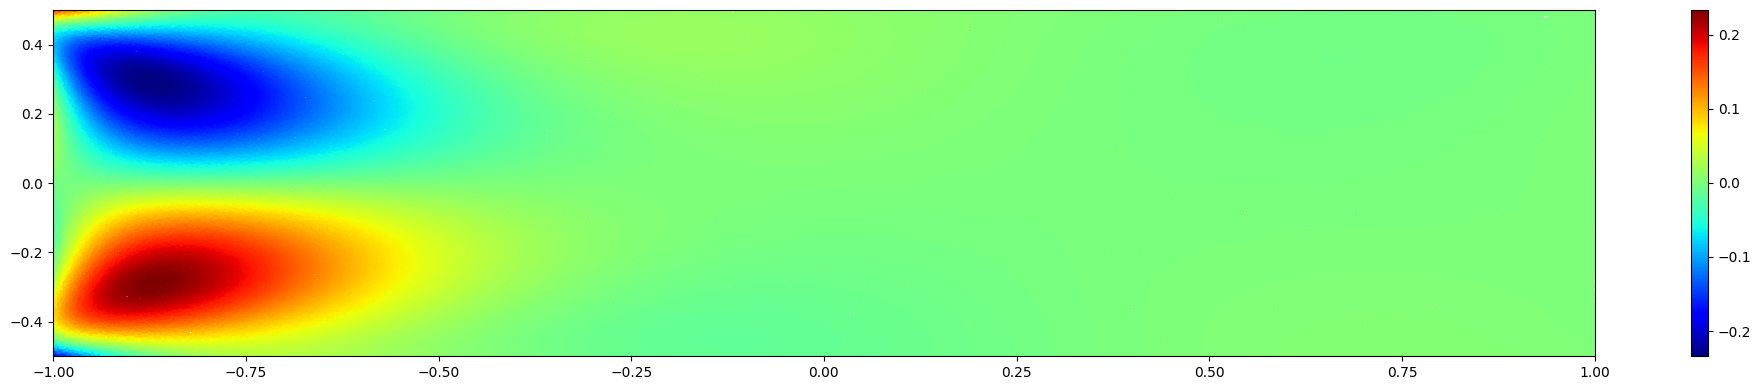

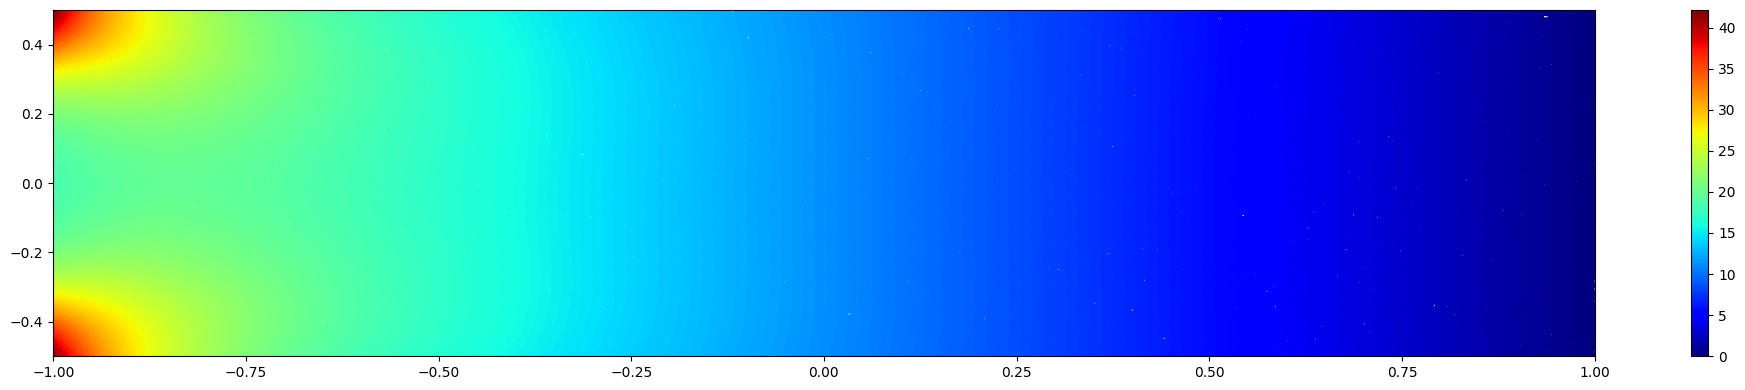

In [18]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'jet',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

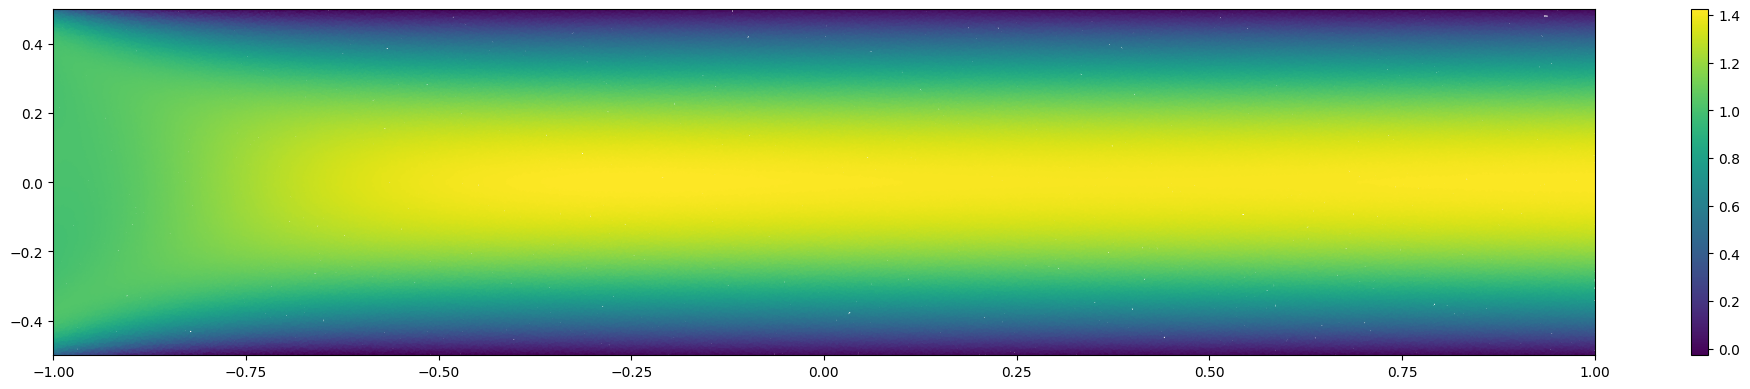

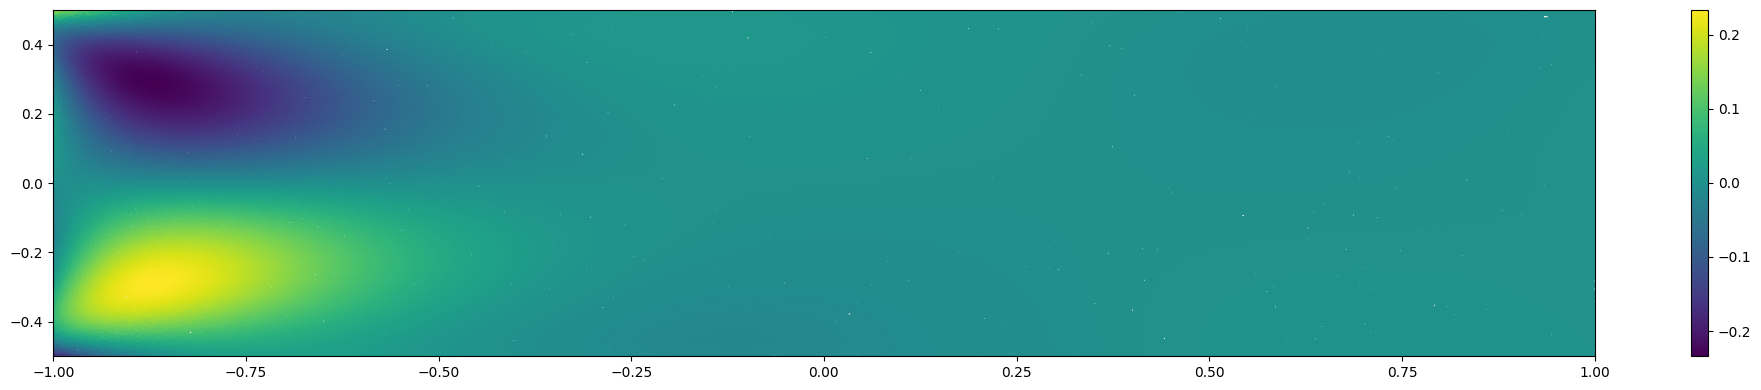

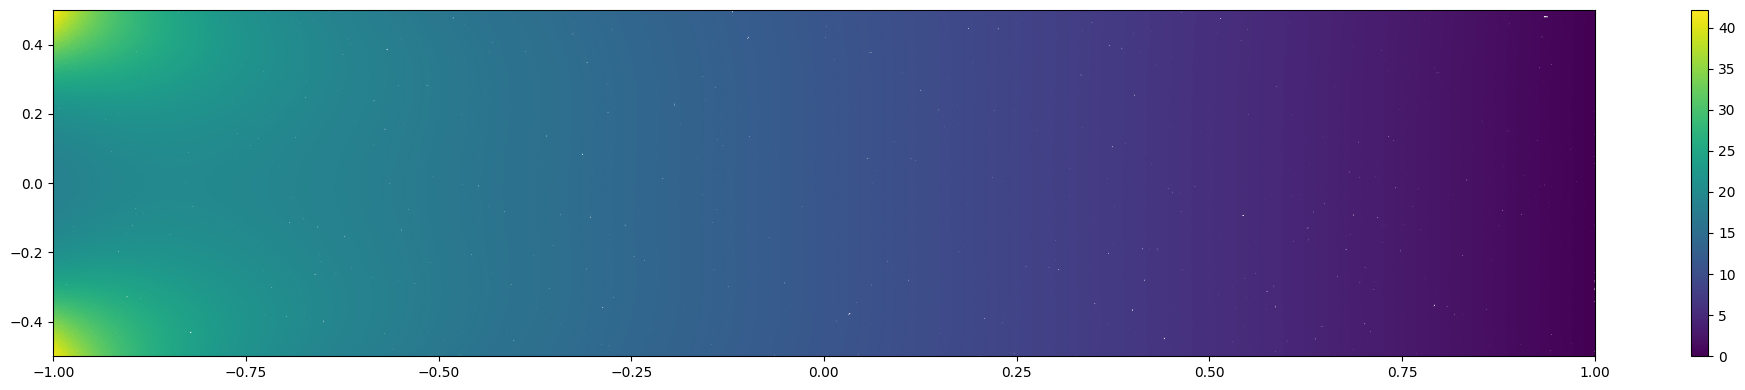

In [19]:
color_legend = [[0,1.5],[-0.3,0.3],[0,35]]

for idx in range(3):
    plt.figure(figsize=(20,4))
    plt.scatter(samples[:,0],
               samples[:,1],
               c = result[:,idx],
               cmap= 'viridis',
               s=2)
    plt.colorbar()
    plt.clim([result[:,idx].min(), result[:,idx].max()])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

# Analytical solution

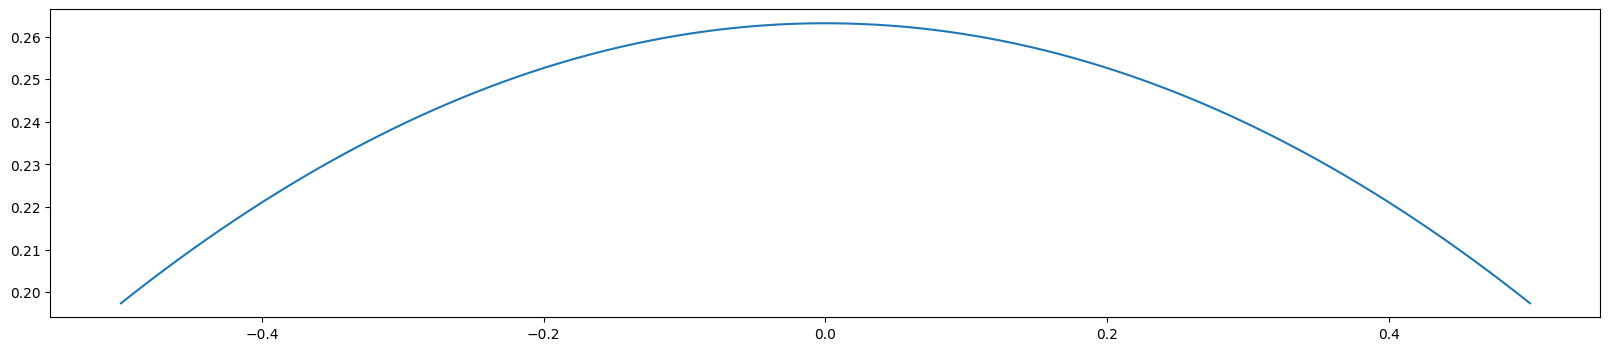

In [20]:
import numpy as np
import matplotlib.pyplot as plt

dp_dx = -1.05263157895 # Pa / m

k = 0.5
R = 1
a = R
b = k * R
r = np.linspace(-0.5, 0.5, 100)
u_analytic = (1 / (4 * mu)) * (- dp_dx)  * (R ** 2 - r ** 2)
# u_analytic = (1 / (4 * mu)) * (- dp_dx)  * (a ** 2 - r ** 2 + ((a ** 2 - b ** 2) / np.log([a / b])[0] * np.log(a / r)))

plt.figure(figsize=(20,4))
plt.plot(r, u_analytic)
plt.show()

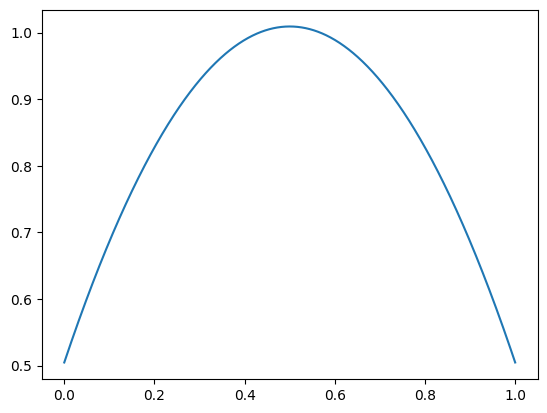

In [10]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 1000)
# x = np.linspace(-0.5, 0.5, 1000)
U = 1
Bi = 0.4
H = 1

u = U / (1 - 3 * Bi + 4 * Bi ** 2) * (3 / 2) * (1 - (2 * (1 / 2 - x / H) ** 2)) - 6 * Bi * (1 - 2 * (1 / 2 - x / H) ** 2)

plt.plot(x, u)
plt.show()